In [144]:
import anndata
import datatable as dt
import numpy as np
import pandas as pd
import re
import scanpy as sc
import scikit_posthocs as sp
import scipy
import seaborn as sns
import statsmodels

#custom functions
import helper_functions_published #see file in Github

In [2]:
sc.logging.print_header()

scanpy==1.7.1 anndata==0.7.5 umap==0.5.1 numpy==1.19.5 scipy==1.5.3 pandas==1.1.5 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.8.3 leidenalg==0.8.3


# set file locations

In [77]:
#download and gunzip the supplementary files from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE193531
metadata_file = "data/GSE193531_cell-level-metadata.csv"
umi_file = "data/GSE193531_umi-count-matrix.csv"
ig_genes_file = "data/ig_locus_genes.txt"

#supplied in source data
H_matrix_file = "outputs/source_data/normalized_H_matrix.csv"
W_matrix_file = '~/GitHub/SignatureAnalyzer-GPU-rpeys/cd138_moreHVG_rmIGproperly/results/nmf_results_3754HVG_take93_W.txt' 

#supplied in supplementary tables
cell_info_file = "outputs/supplementary_tables/cell_info.csv"
NMF_signatures_descriptions_file = "outputs/supplementary_tables/NMF_sig_desc.csv"

# create anndata object

In [4]:
umi = dt.fread(umi_file) #for fast csv reading
umi = umi.to_pandas()
umi.index = umi.C0.tolist()
umi.drop(columns="C0", inplace=True)
umi = umi.astype("float64").transpose()

In [48]:
metadata = pd.read_csv(cell_info_file, index_col=0)

In [49]:
cd138_adata.obs = metadata

In [6]:
cd138_adata = anndata.AnnData(X=umi, obs=metadata)

In [50]:
#order samples by disease stage (useful for visualization)
#order for plotting
cd138_adata.obs.sample_ID = pd.Categorical(cd138_adata.obs.sample_ID, categories=[
    'NBM-1', 'NBM-2', 'NBM-3', 'NBM-4', 'NBM-6', 'NBM-7', 'NBM-8', 'NBM-10', 'NBM-11', 
    'MGUS-1', 'MGUS-2', 'MGUS-3', 'MGUS-4', 'MGUS-5', 'MGUS-6', 
    'SMM-1', 'SMM-2', 'SMM-3', 
    'SMM-4', 'SMM-5', 'SMM-6', 'SMM-7', 'SMM-8', 'SMM-9', 'SMM-10', 'SMM-11', 'SMM-12',
    'MM-1', 'MM-2', 'MM-3', 'MM-4', 'MM-5', 'MM-6', 'MM-7', 'MM-8'], ordered=True)

cd138_adata.obs.disease_stage = pd.Categorical(cd138_adata.obs.disease_stage, categories=[
    'NBM', 'MGUS','SMM', 'MM'], ordered=True)

In [58]:
#change nans from string to NA
cd138_adata.obs.loc[cd138_adata.obs.normal_or_neoplastic=="nan","normal_or_neoplastic"]=None
cd138_adata.obs.normal_or_neoplastic.cat.remove_unused_categories(inplace=True)

In [7]:
#save raw umi's in a layer called 'umi_counts'
cd138_adata.layers['umi_counts'] = cd138_adata.X

### normalize to total count = 10,000 & log data - EXCLUDING genes that account for >20% of genes in some cells

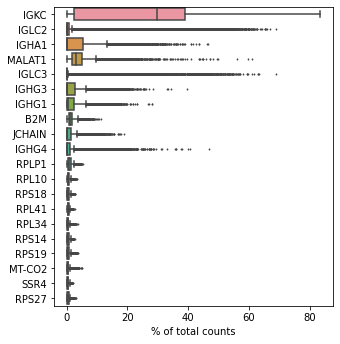

In [8]:
sc.pl.highest_expr_genes(cd138_adata, n_top=20)

In [9]:
sc.pp.normalize_total(cd138_adata, target_sum=1e4, exclude_highly_expressed=True, max_fraction=0.2)
sc.pp.log1p(cd138_adata)

#### save this normalized data in 'raw' slot

In [10]:
cd138_adata.layers['lognorm'] = cd138_adata.X.copy() #log_normalized; this will match raw slot
cd138_adata.raw = cd138_adata

In [11]:
sc.pp.highly_variable_genes(cd138_adata, layer='lognorm', min_mean=0.0125, max_mean=4, min_disp=0.5)

In [12]:
# remove Ig genes, sex genes from HVG list
sex_genes = ['XIST', 'RPS4Y1']
ig_genes = list(pd.read_csv(ig_genes_file).iloc[:,0])
cd138_adata.var.loc[cd138_adata.var.index.isin(ig_genes+sex_genes),'highly_variable'] = False

In [13]:
cd138_adata.var.highly_variable.sum()

1395

#### regress out hemoglobin genes (present due to contamination; potentially driving SMMh-1 and healthies together)

In [14]:
# hemoglobin genes -- likely contamination
r = re.compile("^HB.*")
hemoglobin_genes = list(filter(r.match, cd138_adata.var.index))
#by manual inspection, not all of these are hemoglobin genes, remove those
hemoglobin_genes.remove("HBEGF")
hemoglobin_genes.remove("HBS1L")
hemoglobin_genes.remove("HBP1")

In [15]:
cd138_adata.obs['hemoglobin_score'] = cd138_adata[:,hemoglobin_genes].layers['lognorm'].sum(axis=1)

In [16]:
#this can take a few minutes
sc.pp.regress_out(cd138_adata, keys='hemoglobin_score')

... storing 'sample_ID' as categorical
... storing 'disease_stage' as categorical
... storing 'cluster' as categorical
... storing 'normal_or_neoplastic' as categorical


In [17]:
sc.pp.scale(cd138_adata, max_value=10)

In [18]:
sc.tl.pca(cd138_adata, svd_solver='arpack')

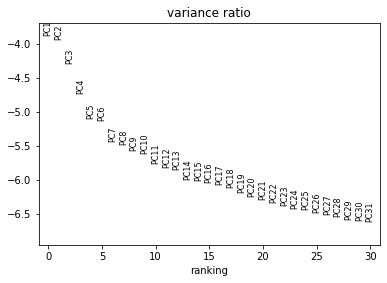

In [19]:
sc.pl.pca_variance_ratio(cd138_adata, log=True)

In [20]:
sc.pp.neighbors(cd138_adata, n_neighbors=15, n_pcs=14)

# create Figure 1

## Figure 1b-d

### (UMAP plots don't match the paper figures exactly when calculated from scratch here; qualitatively, they show the same information.)

In [21]:
sc.tl.umap(cd138_adata)

In [22]:
sc.settings.set_figure_params(figsize=[6,6], dpi=120, format='png')

... storing 'cluster' as categorical
... storing 'normal_or_neoplastic' as categorical


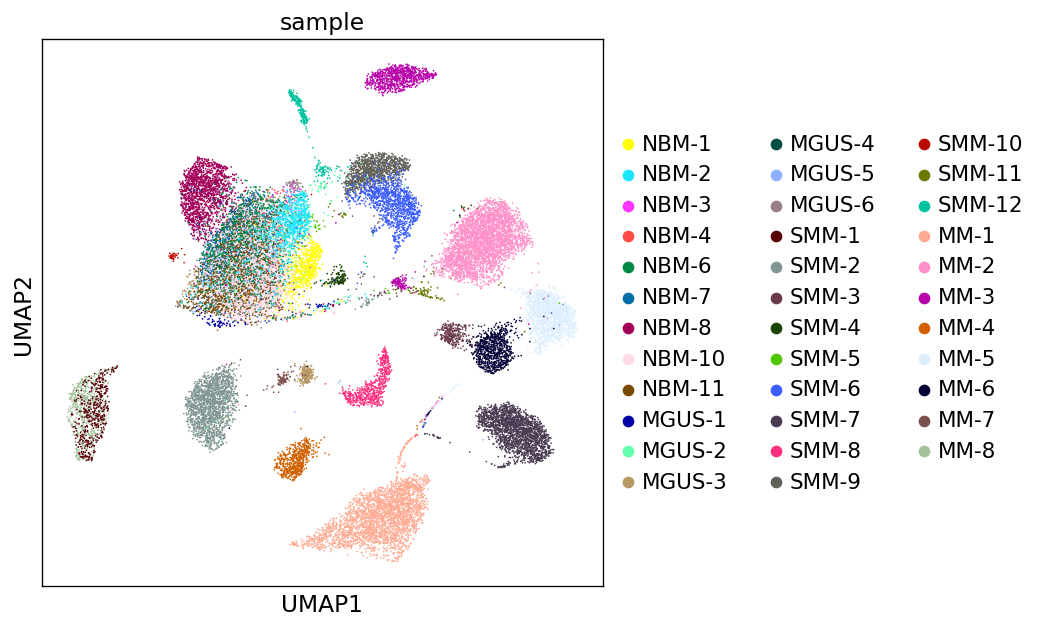

In [33]:
sc.pl.umap(cd138_adata, color="sample_ID", title="sample")

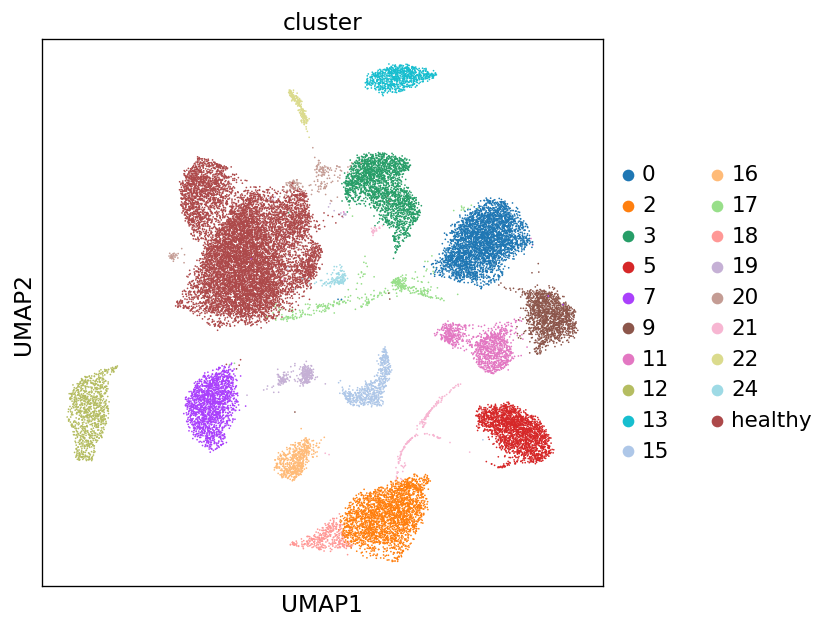

In [24]:
sc.pl.umap(cd138_adata, color="cluster")

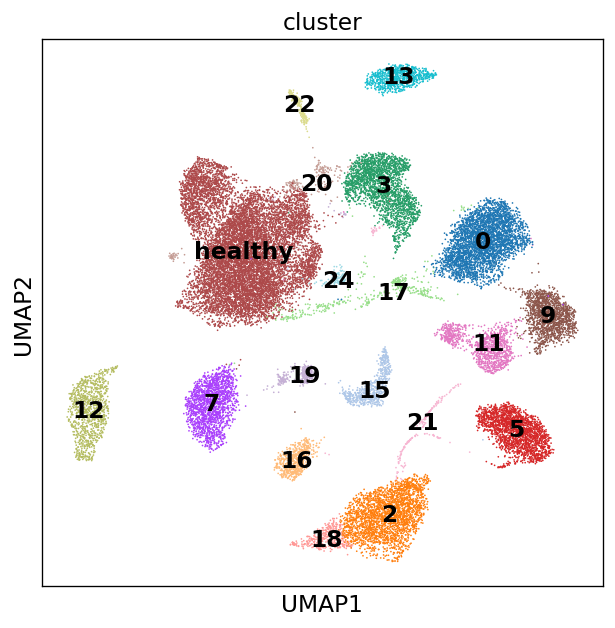

In [25]:
sc.pl.umap(cd138_adata, color="cluster", legend_loc="on data")

... storing 'cluster' as categorical
... storing 'normal_or_neoplastic' as categorical


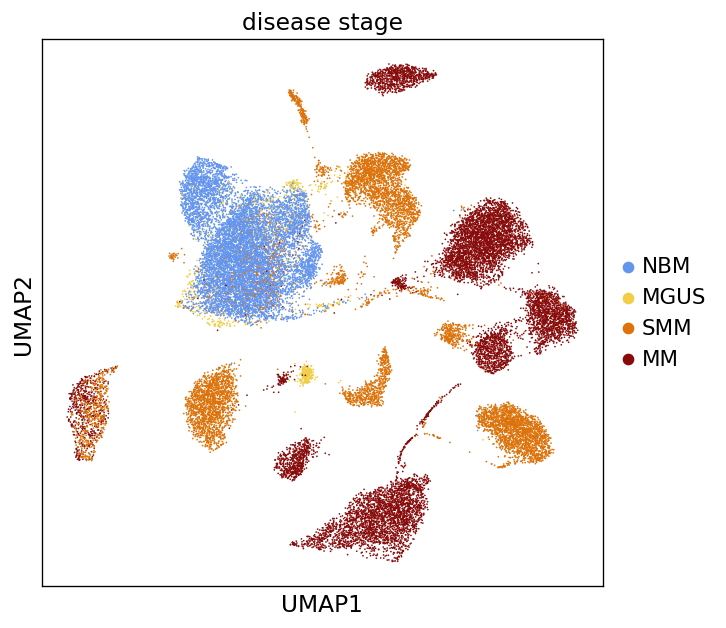

In [46]:
#manually choose disease stage colors
cd138_adata.uns['disease_stage_colors'] = ['cornflowerblue', '#F1CE46', '#DC7209', '#880B0B']
sc.pl.umap(cd138_adata, color="disease_stage", title="disease stage")

## Figure 1e

## Figure 1f

# create Figure 2

## Figure 2a

## Figure 2b

In [54]:
cd138_adata.obs.normal_or_neoplastic.value_counts()

neoplastic    18988
normal        10379
nan              20
Name: normal_or_neoplastic, dtype: int64

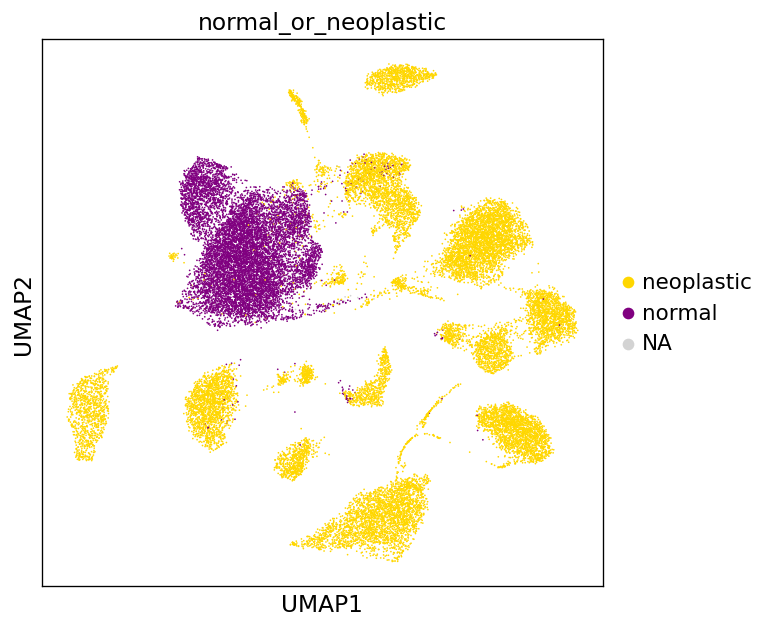

In [59]:
sc.pl.umap(cd138_adata, color="normal_or_neoplastic", palette=['gold','purple'])

## Figure 2c

## Figure 2d

## Figure 2e

## Figure 2f

## Figure 2g

# create Figure 3

In [71]:
H = pd.read_csv(H_matrix_file, index_col=0) #supplied in source data

In [67]:
W = pd.read_csv(W_matrix_file, sep="\t", index_col=0)  #supplied in source data

In [78]:
signatures_desc = pd.read_csv(NMF_signatures_descriptions_file) 
signatures_desc

,signature,description,type,top_genes
0,W1,unknown,NaN,"['JUNB', 'ZFP36', 'NFKBIA', 'IER2']"
1,W2,MM-1,patient specific,"['MTDH', 'HLA-A', 'IFI27', 'SNHG25']"
2,W3,t(11;14) associated,NaN,"['CCND1', 'TSC22D3', 'RP5-887A10.1', 'RGS13']"
3,W4,HLA class II,NaN,"['HLA-DRA', 'HLA-DRB1', 'HLA-DPA1', 'HLA-DPB1']"
4,W5,histones,NaN,"['HIST1H1C', 'HIST1H2AC', 'HIST1H2BC', 'KIAA05..."
5,W6,unknown,NaN,"['DUSP4', 'GADD45A', 'BTG2', 'LAMP5']"
6,W7,MM-4,patient specific,"['IFI6', 'PTP4A3', 'HLA-A', 'LAG3']"
7,W8,t(14;20) associated,NaN,"['ITGB7', 'AC233755.2', 'SPP1', 'CCND2']"
8,W9,extracellular signaling,NaN,"['LGALS1', 'VIM', 'ACTB', 'S100A6']"
9,W10,RPL36A,single gene,"['RPL36A', 'NBEAL1', 'IFITM1', 'LAMP5']"


#### add NMF signature activity to .obs matrix in adata

In [100]:
cd138_adata.obs = cd138_adata.obs.join(H)

In [102]:
cd138_adata.obs['log'+H.columns] = np.log10(H[H.columns]+1)

## Figure 3a

In [82]:
UE = W*H.sum() #total activity for this gene, from this signature (multiply gene activity in signature by the sum of cellular activity from this signature)
FE = (UE.T/UE.T.sum()).T #how much of the genes' activity comes from this signature (specificity of gene to signature)

R=W*FE

R['max'] = R.max(axis=1)
R['max_id'] = np.argmax(R.values,axis=1)+1

In [94]:
df_top_genes_sigs = R.reset_index().rename(columns={"index":"gene"}).drop(columns=['max', 'max_id']).melt(id_vars="gene", var_name="signature").rename(columns={"value":"relative importance"}).sort_values(['signature','relative importance'], ascending=False).groupby('signature').head(10)
#limit figure to 'biologically interpretable' signatures
df_top_genes_sigs = df_top_genes_sigs.merge(signatures_desc[(pd.isna(signatures_desc.type))&(~(signatures_desc.description=="unknown"))], on="signature")
df_top_genes_sigs.loc[df_top_genes_sigs.description=="protein synthesis (ser/thr kinase; elongation factors; pre/mRNA editing)","description"]="protein synthesis"
df_top_genes_sigs['title'] = df_top_genes_sigs.signature+": "+df_top_genes_sigs.description

In [97]:
#for figure, I want there to be 9 facets, not 10. will drop 'extracellular signaling' and 'nuclear genes' (the latter is just a QC issue due to some cells having high MALAT1)
df_top_genes_sigs = df_top_genes_sigs[df_top_genes_sigs.signature!="W9"]
df_top_genes_sigs = df_top_genes_sigs[df_top_genes_sigs.signature!="W27"]

/opt/conda/rpeyser/envs/mm_singlecell_v2/lib/python3.6/site-packages/seaborn/categorical.py:3805: UserWarning: Setting `sharey=False` with `color=None` may cause different levels of the `y` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharey", "y"), UserWarning)


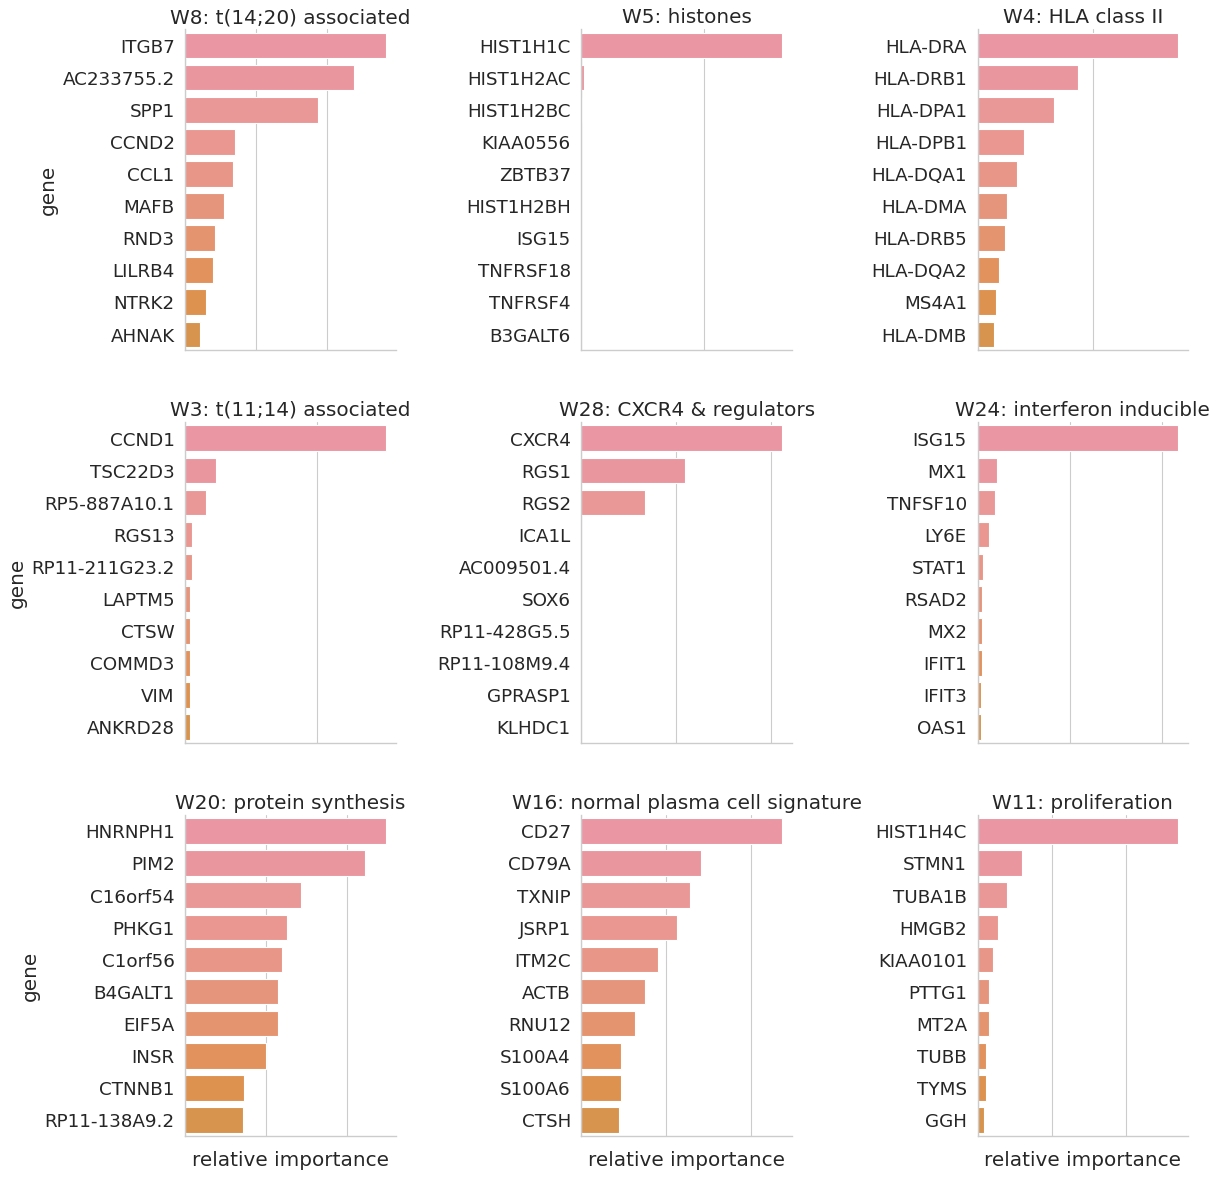

In [98]:
sc.settings.set_figure_params(dpi=80, facecolor='white', format='png')
sns.set(style="whitegrid", font_scale=1.5)
g = sns.catplot(data=df_top_genes_sigs, y="gene", x="relative importance", col="title", col_wrap=3, kind="bar", sharex=False, sharey=False)
g.set_titles(template='{col_name}')
g.set(xticklabels=[]) #no need for xtick labels

## Figure 3b

### validation with CCND1 signature

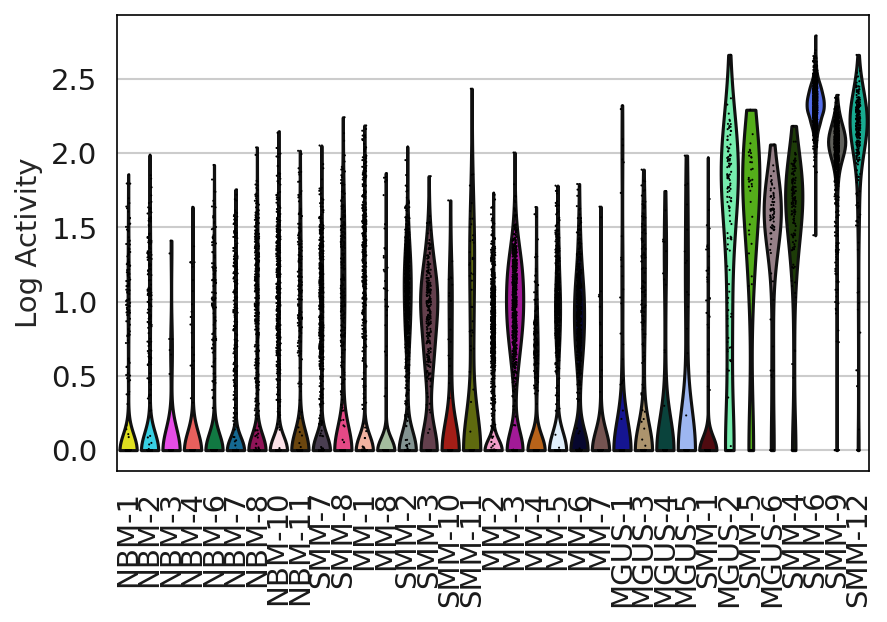

In [107]:
sc.settings.set_figure_params(figsize=[6,4], dpi=150, format='png')
sc.pl.violin(cd138_adata, keys="logW3", groupby="sample_ID", rotation=90, ylabel="Log Activity",
    order=[
    'NBM-1', 'NBM-2', 'NBM-3', 'NBM-4', 'NBM-6', 'NBM-7', 'NBM-8', 'NBM-10', 'NBM-11', #NBM
    'SMM-7', 'SMM-8', 'MM-1', #t(4;14)
    'MM-8', #t(14;20)
    'SMM-2', 'SMM-3','SMM-10', 'SMM-11', 'MM-2', 'MM-3', 'MM-4','MM-5', 'MM-6','MM-7', #hyperdiploid (only. some translocated are also HRD)
    'MGUS-1', 'MGUS-3', 'MGUS-4', 'MGUS-5', 'SMM-1', 'MGUS-2','SMM-5', #insufficient cells
     'MGUS-6', 'SMM-4', 'SMM-6', 'SMM-9', 'SMM-12', #t(11;14)    
    ])
sc.settings.set_figure_params(figsize=[6,6], dpi=150, format='png')

## Figure 3c

### Analyze Signatures Across Disease Stages

In [162]:
person_mean_activity_long = cd138_adata.obs.groupby(['sample_ID','normal_or_neoplastic'])[H.columns].mean().reset_index().merge(cd138_adata.obs[['sample_ID','disease_stage']], left_on="sample_ID", right_on="sample_ID").drop_duplicates().reset_index().drop(columns="index").melt(id_vars=["sample_ID", "normal_or_neoplastic", "disease_stage"], var_name="signature", value_name='mean_activity')
person_mean_activity_long = person_mean_activity_long.dropna() #drop columns with NA under mean_activity
person_mean_activity_long = person_mean_activity_long.merge(signatures_desc, left_on="signature", right_on="signature").rename(columns={'desc':'signature_desc'})
#add std
person_mean_activity_long = cd138_adata.obs.groupby(['sample_ID','normal_or_neoplastic'])[H.columns].std().reset_index().melt(id_vars=["sample_ID", "normal_or_neoplastic"], var_name="signature", value_name='stdev').merge(person_mean_activity_long, left_on=['sample_ID','normal_or_neoplastic','signature'], right_on=['sample_ID','normal_or_neoplastic','signature'])
#add n
person_mean_activity_long = cd138_adata.obs.groupby(['sample_ID','normal_or_neoplastic']).size().reset_index().rename(columns={0:'n'}).merge(person_mean_activity_long, left_on=['sample_ID','normal_or_neoplastic'], right_on=['sample_ID','normal_or_neoplastic'])

In [163]:
person_mean_activity_long['title'] = person_mean_activity_long.signature + ' (' + person_mean_activity_long.description + ')'

In [164]:
person_mean_activity_long['group'] = person_mean_activity_long.disease_stage.astype(str) + ' ' + person_mean_activity_long.normal_or_neoplastic.astype(str)

#### calculate standard error, to include in plot below

In [ ]:
#calculate std error of mean
bootstrapped_means = helper_functions_published.bootstrap_means_sigs(cd138_adata, sig_colnames=signif_sigs2, groupby_vars=['sample_ID','normal_or_neoplastic'], n_bootstrap=10000)

In [159]:
boot_SE = helper_functions_published.calc_boot_SE(bootstrapped_means, groupby_vars=['sample_ID','normal_or_neoplastic'])

In [160]:
boot_SE = boot_SE.dropna()

In [166]:
person_mean_activity_long = person_mean_activity_long.merge(boot_SE, on=['sample_ID','normal_or_neoplastic','signature'], how="outer")

In [167]:
person_mean_activity_long

,sample_ID,normal_or_neoplastic,n,signature,stdev,disease_stage,mean_activity,description,type,top_genes,title,group,stderror
0,NBM-1,normal,760,W1,18.239266,NBM,13.626664,unknown,NaN,"['JUNB', 'ZFP36', 'NFKBIA', 'IER2']",W1 (unknown),NBM normal,NaN
1,NBM-1,normal,760,W2,4.972110,NBM,1.563987,MM-1,patient specific,"['MTDH', 'HLA-A', 'IFI27', 'SNHG25']",W2 (MM-1),NBM normal,NaN
2,NBM-1,normal,760,W3,7.465172,NBM,2.290287,t(11;14) associated,NaN,"['CCND1', 'TSC22D3', 'RP5-887A10.1', 'RGS13']",W3 (t(11;14) associated),NBM normal,0.267637
3,NBM-1,normal,760,W4,8.010413,NBM,2.916350,HLA class II,NaN,"['HLA-DRA', 'HLA-DRB1', 'HLA-DPA1', 'HLA-DPB1']",W4 (HLA class II),NBM normal,NaN
4,NBM-1,normal,760,W5,0.910435,NBM,0.307942,histones,NaN,"['HIST1H1C', 'HIST1H2AC', 'HIST1H2BC', 'KIAA05...",W5 (histones),NBM normal,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1283,MM-8,neoplastic,553,W24,7.719305,MM,2.548051,interferon inducible,NaN,"['ISG15', 'MX1', 'TNFSF10', 'LY6E']",W24 (interferon inducible),MM neoplastic,0.327144
1284,MM-8,neoplastic,553,W25,8.357617,MM,7.497198,UBC,single gene,"['UBC', 'C1GALT1C1', 'SLC3A2', 'LMF1']",W25 (UBC),MM neoplastic,NaN
1285,MM-8,neoplastic,553,W26,26.265181,MM,24.947668,unknown,NaN,"['HLA-A', 'ITM2C', 'PRR15', 'ACTB']",W26 (unknown),MM neoplastic,NaN
1286,MM-8,neoplastic,553,W27,163.759501,MM,282.883017,nuclear genes (opposite expression pattern to ...,NaN,"['NEAT1', 'DDX17', 'ANKRD12', 'FOXO3']",W27 (nuclear genes (opposite expression patter...,MM neoplastic,NaN


## test for significance - Kruskal-Wallis + Dunns
#### First summarize each patient by their mean activity for each sig. 
#### Then use Kruskal-Wallis to test whether the mean of mean expression among patients in different disease stages differ, with Bonferroni correction (q<0.1)
#### Then use Dunns to find out where the significant differences are (Bonferroni q<0.1) 
#### multiply by number of sigs tested to further correct fpr multiple hypotheses (FWER)

In [137]:
kw_pvals = []
for sig in signatures_desc[pd.isna(signatures_desc.type)].signature: #only test non single patient/gene sigs
    a=person_mean_activity_long[(person_mean_activity_long.signature==sig) & (person_mean_activity_long.disease_stage=='NBM')].mean_activity
    b=person_mean_activity_long[(person_mean_activity_long.signature==sig) & (person_mean_activity_long.normal_or_neoplastic=='neoplastic') & (person_mean_activity_long.disease_stage=='MGUS')].mean_activity
    c=person_mean_activity_long[(person_mean_activity_long.signature==sig) & (person_mean_activity_long.normal_or_neoplastic=='neoplastic') & (person_mean_activity_long.disease_stage=='SMM')].mean_activity
    d=person_mean_activity_long[(person_mean_activity_long.signature==sig) & (person_mean_activity_long.normal_or_neoplastic=='neoplastic') & (person_mean_activity_long.disease_stage=='MM')].mean_activity
    e=person_mean_activity_long[(person_mean_activity_long.signature==sig) & (person_mean_activity_long.normal_or_neoplastic=='normal') & (person_mean_activity_long.disease_stage=='MGUS')].mean_activity
    f=person_mean_activity_long[(person_mean_activity_long.signature==sig) & (person_mean_activity_long.normal_or_neoplastic=='normal') & (person_mean_activity_long.disease_stage=='SMM')].mean_activity
    g=person_mean_activity_long[(person_mean_activity_long.signature==sig) & (person_mean_activity_long.normal_or_neoplastic=='normal') & (person_mean_activity_long.disease_stage=='MM')].mean_activity
    res = scipy.stats.kruskal(a,b,c,d,e,f,g)
    kw_pvals.append(res[1])

In [139]:
signif_sigs=[]
#correct KW using Bonferonni and find signif sigs to feed into post-hoc test
for sig in signatures_desc[pd.isna(signatures_desc.type)].signature[statsmodels.stats.multitest.multipletests(kw_pvals, alpha=0.1, method='bonferroni')[0]]:
    signif_sigs.append(sig)
    print(sig + " (" + signatures_desc.loc[signatures_desc.signature==sig,"description"] + ")")# statistically different between disease stages! " + str(res))

2    W3 (t(11;14) associated)
Name: description, dtype: object
15    W16 (normal plasma cell signature)
Name: description, dtype: object
23    W24 (interferon inducible)
Name: description, dtype: object


In [142]:
#there are 9 pairwise tests I care about - each malignant group vs. NBM, each healthy group across disease stages vs. NBM, each malignant group across disease stages vs. each other
#Dunn follow up tests
signif_sigs2 = []
for sig in signif_sigs:
    res = sp.posthoc_dunn(person_mean_activity_long.loc[person_mean_activity_long.signature==sig,["mean_activity","group"]], group_col="group", val_col="mean_activity", p_adjust=None)
    res = pd.melt(res.reset_index().rename(columns={'index':'group1'}), id_vars="group1", var_name="group2", value_name="qval").drop_duplicates() #drop_dup because matrix was symmetric
    res['FWER_q']= res.qval*9
    res = res[res.FWER_q<0.1]
    if len(res)>0:
        print(sig + " (" + signatures_desc.loc[signatures_desc.signature==sig,"description"] + ")")
        signif_sigs2.append(sig)
        print(res)
        print("\n")

2    W3 (t(11;14) associated)
Name: description, dtype: object
             group1           group2      qval    FWER_q
4        NBM normal  MGUS neoplastic  0.006301  0.056706
25       NBM normal        MM normal  0.006301  0.056706
28  MGUS neoplastic       NBM normal  0.006301  0.056706
31        MM normal       NBM normal  0.006301  0.056706
33   SMM neoplastic       NBM normal  0.001511  0.013599
39       NBM normal   SMM neoplastic  0.001511  0.013599


15    W16 (normal plasma cell signature)
Name: description, dtype: object
            group1          group2          qval    FWER_q
9    MM neoplastic     MGUS normal  1.321890e-04  0.001190
12  SMM neoplastic     MGUS normal  1.907858e-03  0.017171
15     MGUS normal   MM neoplastic  1.321890e-04  0.001190
18      NBM normal   MM neoplastic  1.493094e-07  0.000001
20      SMM normal   MM neoplastic  3.175865e-03  0.028583
30   MM neoplastic      NBM normal  1.493094e-07  0.000001
33  SMM neoplastic      NBM normal  3.702396e-06 

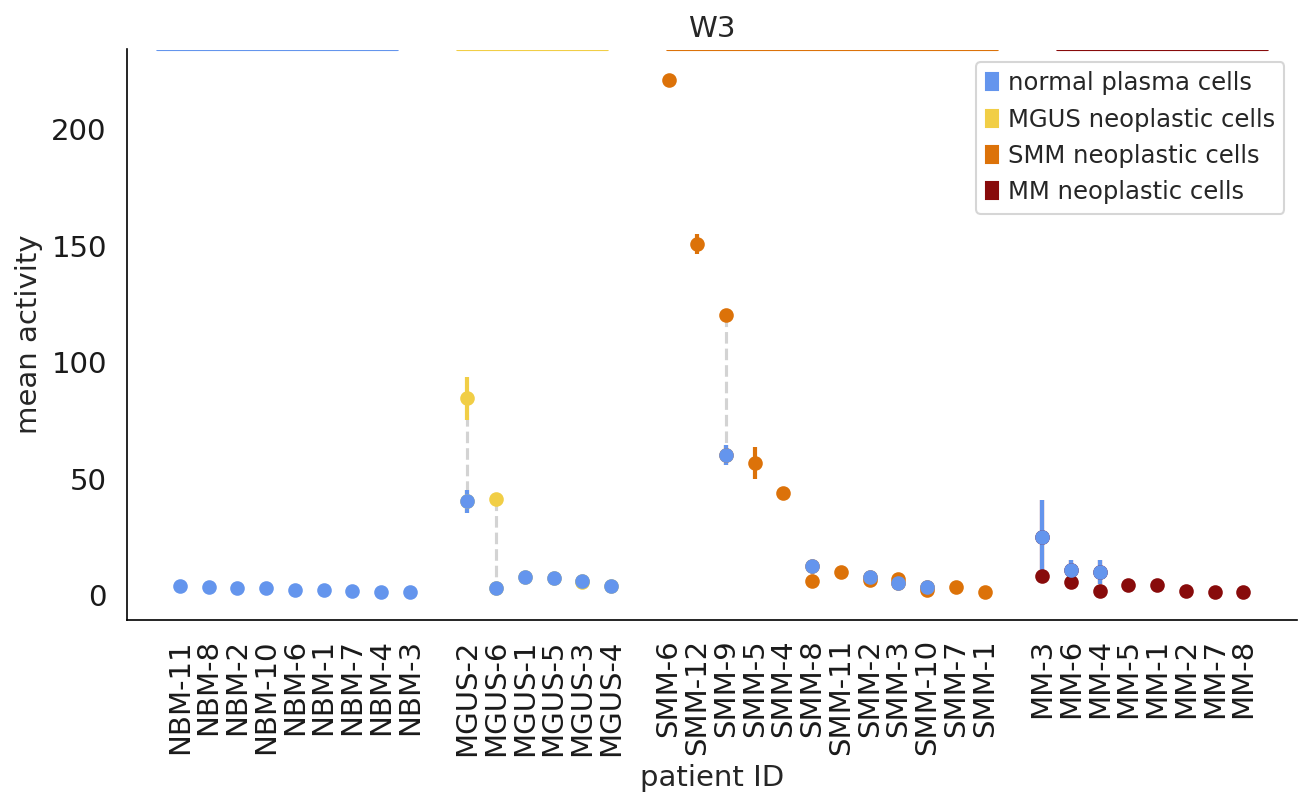

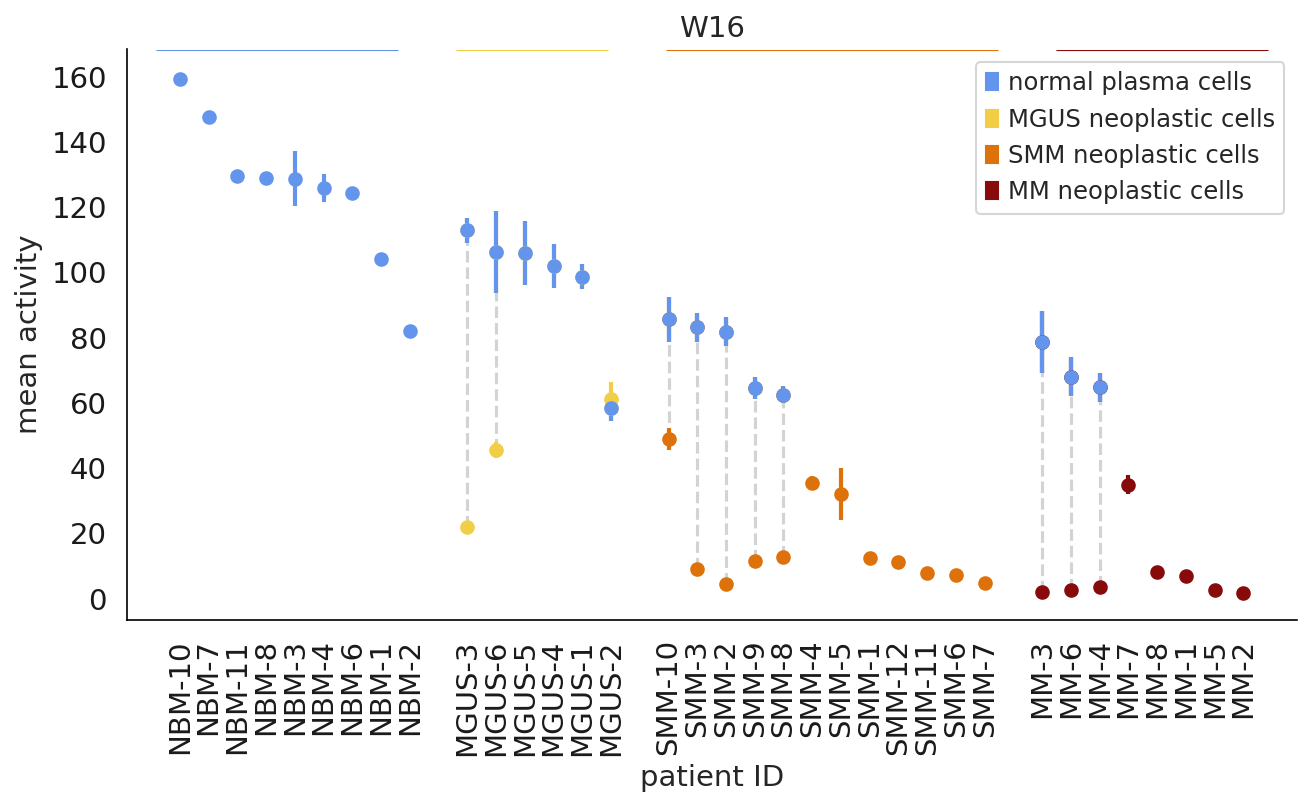

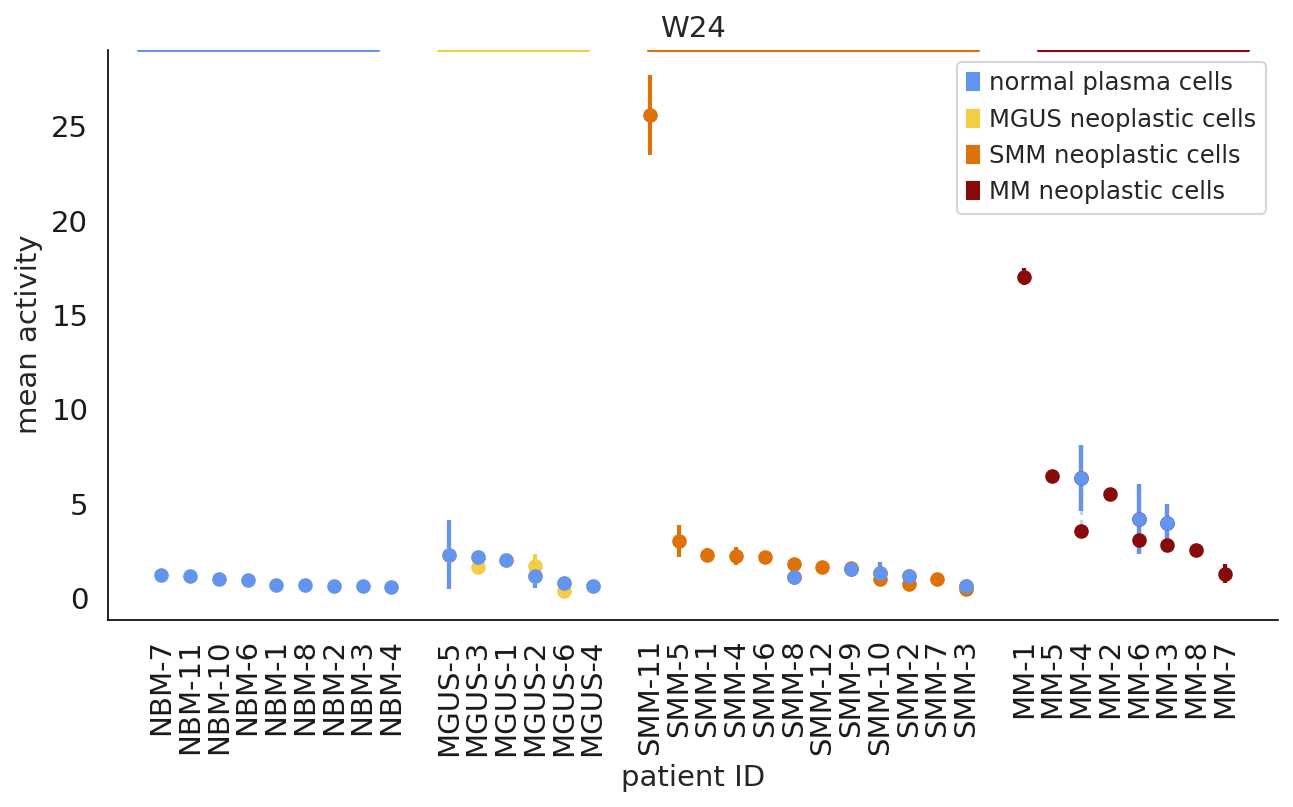

In [170]:
for sig in signif_sigs2: #need to loop because xticklabels arent working properly otherwise
    helper_functions_published.plot_per_patient_healthymalig(person_mean_activity_long, [sig], facet_col='signature', value_col='mean_activity', 
                                                             sample_col='sample_ID', label_col="normal_or_neoplastic", normalcells="normal", 
                                                             ds_colors=cd138_adata.uns["disease_stage_colors"], ylabel='mean activity', ncols=1, ptsize=6, 
                                                             sharey=False, sharex=False, figsize=None, dpi=180)
    

## Figure 3d

## Figure 3e

## Figure 3f

# Figure 4

## Figure 4a

## Figure 4b

## Figure 4c